# SPINSpy Tutorial: 

>This document will (hopefully) show you everything that you need to know to be able to process your SPINS outputs using python (why python? Because it's not MATLAB). This tutorial will assume that you have a basic understanding of python syntax.
>
>To begin, we import some useful packages. Base python is fairly bare-bones, but you'll find that there's a package for almost anything that you want.

In [1]:
%matplotlib inline 
# Tells the system to plot in-line, only necessary for iPython notebooks,
# not regular commandline python
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import time

>Now that we have some packages to work with, let's see what files we have. These sample files, provided by (more correctly stolen from) David, and are part of a mode-2 simulation.
>
>* __rho.15__: binary file with the output 15 of the density field
>* __[x,y,z]grid__: binary file with the grids
>* __matpy__: a package with some useful functions (such as darkjet, just for you Marek)
>* __spinspy__: a package with the SPINS readers

>If we want to use our shiny python scripts, we'll need to import them too.

In [2]:
import spinspy as spy
import matpy as mp

> If we want a quick man-page style summary, we can call `help(spy)`

In [3]:
help(spy)

Help on package spinspy:

NAME
    spinspy

FILE
    /work/ddeepwel/SPINSpy/spinspy/__init__.py

DESCRIPTION
    # SPINSPY
    #   This module contains functions that are
    #   designed to handle SPINS-type outputs.
    #   The provided functions are listed below,
    #   along with basic usage information.

PACKAGE CONTENTS
    get_diagnostics
    get_shape
    grid
    make_movie
    reader
    spinspy_classes

FUNCTIONS
    get_diagnostics(fp='diagnostics.txt')
        ## ------------------
        ## get_diagnostics: Parse diagnostics.txt
    
    get_shape()
        ## Determine simulation parameters
        ## Purpose:
        ##     If spins.conf exists
        ##         parse spins.conf
        ##     Else
        ##         Use hard-coded values
        ##
        ## Usage:
        ##     data = spinspy.get_shape()
        ##
        ##     data.display() prints a summary
        ##                    of known values
        ## ------
    
    grid(type='vector')
        ##

## Reading Full Files

>Now that we have all of our tools, let's start doing! To begin, let's load our density field.

In [8]:
cd /scratch/orca/scratch/kglamb/ddeepwel/asymkh/

/scratch/orca/scratch/kglamb/ddeepwel/asymkh


In [9]:
ls rho.*

rho.0   rho.13  rho.18  rho.22  rho.27  rho.31  rho.36  rho.40  rho.45  rho.5
rho.1   rho.14  rho.19  rho.23  rho.28  rho.32  rho.37  rho.41  rho.46  rho.6
rho.10  rho.15  rho.2   rho.24  rho.29  rho.33  rho.38  rho.42  rho.47  rho.7
rho.11  rho.16  rho.20  rho.25  rho.3   rho.34  rho.39  rho.43  rho.48  rho.8
rho.12  rho.17  rho.21  rho.26  rho.30  rho.35  rho.4   rho.44  rho.49  rho.9


In [34]:
rho = spy.reader('rho', 30, [0,-1], [0,-1], [0,-1])

>What the heck did that just do? Let's break it down and look at the inputs.
>
>* `'rho'` : This tells the function which variable to load (in this case, rho)
>* `15` : This is the index, so we will load rho.15. _x,y,z_ variables done take an index.
>* `[0,-1]` : The x-range to load. This is shorthand and is equivalent to ':' from MATLAB. 
>* `[0,-1]` : The y-range
>* `[0,-1]` : The z-range
>
>Here we have loaded the entire thing. Alternatively, you could have given a single value or a list of indices. That is, giving `0` would take the first slice, `[0,100]` takes the first 100 elements, and `[0,2,4,6]` takes the first, third, fifth, and, seventh elements.
>
> To load an x-z slice we could have done:
>`rho = spy.reader('rho',15,[0,-1],0,[0,-1])`

In [28]:
rho.shape

(512, 128, 96)

>Note that this is ordered as (Nx,Ny,Nz). If we had wanted MATLAB style ordering (Ny,Nx,Nz), we could have used the optional argument `ordering = 'matlab'` (useful for some plotting). The default is `ordering = 'natural'` (useful because it feels right).

>If we had high resolution or wanted to load multiply variables into memory simultaneously, we might start running into memory issues. For example, let's look at the size of rho.

In [29]:
(rho.nbytes)/(1024.0**2)

48.0

>So rho is taking up about 800 mb of memory. We could easily imagine a higer resolution grid taking up much more, quickly eating up all available memory. Instead, it may be useful to only load a single 1D or 2D slice. This is particularly true with the grids (since we only need a 1D vector to describe each dimension) and when we want to make 2D plots (such as pcolor or contour). Let's look at that now.

## Loading Parts of Files

>To begin, let's load in our grid. We know that they only need to be 1D objects, so they should be pretty small. Remember, for loading `x`, `y`, or `z` there is no index value (the 15 from the rho loading call). Notice that the reader automatically squeezes out any singleton dimensions, so our grid vectors are actually vectors!

In [30]:
x = spy.reader('x', [0,-1],0,0)
y = spy.reader('y', 0,[0,-1],0)
z = spy.reader('z', 0,0,[0,-1])

In [31]:
print('The shape of x is {0} and it takes up {1}kb.'.format(x.shape, x.nbytes/(1024.0)))
print('The shape of y is {0} and it takes up {1}kb.'.format(y.shape, y.nbytes/(1024.0)))
print('The shape of z is {0} and it takes up {1}kb.'.format(z.shape, z.nbytes/(1024.0)))

The shape of x is (512,) and it takes up 4.0kb.
The shape of y is (128,) and it takes up 1.0kb.
The shape of z is (96,) and it takes up 0.75kb.


>Perfect, now we have our grid vectors and they are fairly small (a few kb). The readers package also provides a function to let you load in all of the grid vectors in one fell swoop.

>`x,y,z = spy.grid()`

> We can also load in grid information, such as the domain size and limits. This is stored in a class that has a method called `display'. These are illustrated below.

In [32]:
data = spy.get_shape()
print(data.Nx,data.Ny,data.Nz)
print('---')
data.display()

(512, 128, 96)
---
3-dimensional simulation:
  x-Dimension:
    Number of Points: 512
    Length of Domain: n/a
    Bounds of Domain: n/a
    Type: None
  y-Dimension:
    Number of Points: 128
    Length of Domain: n/a
    Bounds of Domain: n/a
    Type: None
  z-Dimension:
    Number of Points: 96
    Length of Domain: n/a
    Bounds of Domain: n/a
    Type: None
Other parameters:
Settings:


## Plotting

>We now have our grid vectors and rho field loaded into memory, so it's time to try some plotting! A standard plotting library in python is matplotlib, which replicates many of MATLAB's plotting functions. For example, here we have a pcolor and contour plot of an x-z slice of rho.

Time to plot: 1.05e-01


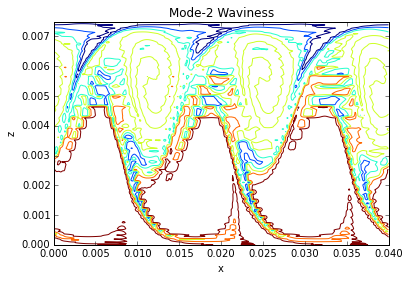

In [35]:
rho = spy.reader('rho', 30, [0,-1], [0,-1], [0,-1])
plt.figure(1)
t0 = time.clock()
plt.contour(x,z,rho[:,192/2,:].transpose());
t1 = time.clock()
print('Time to plot: {0:1.2e}'.format(t1-t0))
plt.title('Mode-2 Waviness');
plt.xlabel('x');
plt.ylabel('z');

Time to plot: 3.27e+00


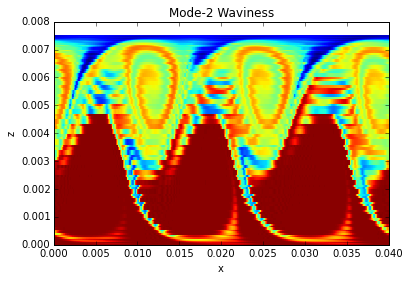

In [37]:
rho = spy.reader('rho', 30, [0,-1], [0,-1], [0,-1])
plt.figure(2)
t0 = time.clock()
plt.pcolor(x,z,rho[:,1,:].transpose());
t1 = time.clock()
print('Time to plot: {0:1.2e}'.format(t1-t0))
plt.title('Mode-2 Waviness');
plt.xlabel('x');
plt.ylabel('z');

Time to plot: 5.22e-02


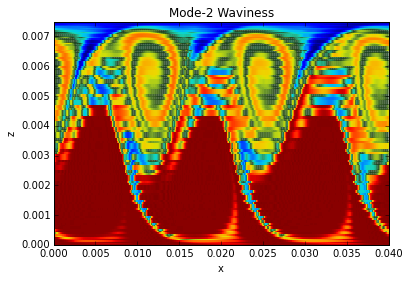

In [39]:
rho = spy.reader('rho', 30, [0,-1], [0,-1], [0,-1])
plt.figure(3)
t0 = time.clock()
plt.pcolormesh(x,z,rho[:,192/2,:].transpose(), cmap='darkjet')
t1 = time.clock()
print('Time to plot: {0:1.2e}'.format(t1-t0))
plt.title('Mode-2 Waviness')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('tight')
plt.show()
#plt.gca().set_xlim((data.xlim[0],data.xlim[1]))
#plt.gca().set_ylim((data.zlim[0],data.zlim[1]))

>We've just seen three examples of 2D plots: `contour`, `pcolor`, and `pcolormesh` (`contourf` also exists). In general, if you'll be working with high resolution rectangular grids, choose `pcolormesh` over `pcolor` as it is cheaper on memory and time. The time taken for each plot was printed when you made the plots and pcolormesh was two orders of magnitude faster!
>
>Also, both `pcolor` and `pcolormesh` have the unfortunate habit of adding extra white space, so you will often need to specify the axis limits.
>
>Most MATLAB colour maps are also available in matplotlib, you just need to set the optional argument `cmap='colourmap_name'`.